In [2]:
%pylab inline
%config InlineBackend.figure_format = 'retina'
from scipy.integrate import solve_ivp

Populating the interactive namespace from numpy and matplotlib


## Explusion analysis

Given a water rocket of total internal volume $V_t$, nozzle area $A_t$ and filled with water to a fill fraction, $\alpha = \frac{V_{w0}}{V_t}$, and dry mass $m_s$ we would like to develop a model for the thrust produced.

First we will assume that as the rocket expels water, the gas left in the tank expands following a process of the form

$$pV^n = \text{const}$$

There are three interesting limiting cases of this process:

- For $n=0$, this is a *isobaric (constant pressure)* process
- For $n=1$, this is an *isothermal (constant temperature)* process
- For $n=\gamma$ this is an *isentropic (constant entropy)* process

The isobaric ($n=0$) case is not terribly interesting because to maintain constant pressure in a rapidly expanding volume would almost certainly require an external flow of gas into the volume from some other source.  

The isothermal case ($n=1$) can be seen as a limiting case where the explusion is extremely slow.  In this case there is both work done on the liquid being expelled ($\delta W \neq 0$) and sufficient heat transfer rate ($\delta Q \neq 0$) to keep the gas at a constant temperature during expansion.

The isentropic case ($n=\gamma$) is the most relevant because it models an expansion process that still performs work on the liquid ($\delta W \neq 0$) but with no heat transfer to the gas ($\delta Q = 0$).  Given the rapidity of the explusion and the various heat transfer coefficients involved, this is a pretty good assumption.

We can thus say

$$p(t)V(t)^n = p_0(1 - \alpha)^nV_t^n$$

or

$$p(t) = (1 - \alpha)^np_0\left[\frac{V_t}{V(t)}\right]^n$$

Since the water is effectively incompressible, we can assume that it exits the nozzle at the local ambient pressure, $p_a$ and use Bournouli's equation to compute its velocity:

$$U_e = \sqrt{\frac{2 \left[p(t) - p_a\right]}{\rho_{w}}}$$

Given a nozzle exit area $A_e$ we can thus compute thrust as

$$T = \dot{m} U_e = \rho_{w} U_e^2 A_e$$

We can also use conservation of momentum to note that for a small differential mass expelled, $dm$:

$$m_r dU_r = U_e dm = \rho_{w} U_e dV$$

Assuming the mass of gas in the bottle is negligible compared with other masses, we can then write:

$$\left[\rho_w (V_t - V(t)) + m_s\right] dU_r = \rho_{w}U_e dV$$

or

$$dU_r = \frac{\sqrt{2\rho_w \left[(1 - \alpha)^np_0\left[\frac{V_t}{V(t)}\right]^n - p_a\right]}}{\rho_w \left[V_t - V(t)\right) + m_s}dV$$

substituting $\mu = \frac{V}{V_t}$ and $dV = V_t d\mu$:

$$dU_r = \frac{\sqrt{2\rho_w \left[(1 - \alpha)^np_0\mu^{-n} - p_a\right]}}{\rho_w V_t\left[1 - \mu\right] + m_s}V_td\mu$$

The goal is to then integrate this

$\mu = (1-\alpha)$ to $\mu = 1$ 

$$\int_0^{\Delta U_r} dU_r = \Delta U_r = \int_{1-\alpha}^1\frac{\sqrt{2\rho_w \left[(1 - \alpha)^np_0\mu^{-n} - p_a\right]}}{\rho_w V_t\left[1 - \mu\right] + m_s}V_td\mu$$

and compute the increment in rocket velocity.

## Constants
Re-run the cell below with new values before you try any run the subsequent cells.

In [3]:
rho_w = 1000.        # kg / m^3
p0 = 7e5             # Pa
Vt = 2. * 1e-3       # m^3
pa = 1e5
ms = 0.052            # kg
ml = 0.065            # kg
mf = 0.065            # kg
n = 1.4

rho_a = 1.2           #kg/m^3
Cd = 0.45
d_bottle = 10e-2
Af = pi * (d_bottle)**2 / 4.   # m^2
Ae = pi * (1e-2)**2 / 4.  # m^2
l = 33e-2             # m
g0 = 9.81             # m/s^2
alpha = 0.4

Maximum acceleration: 21.3 G


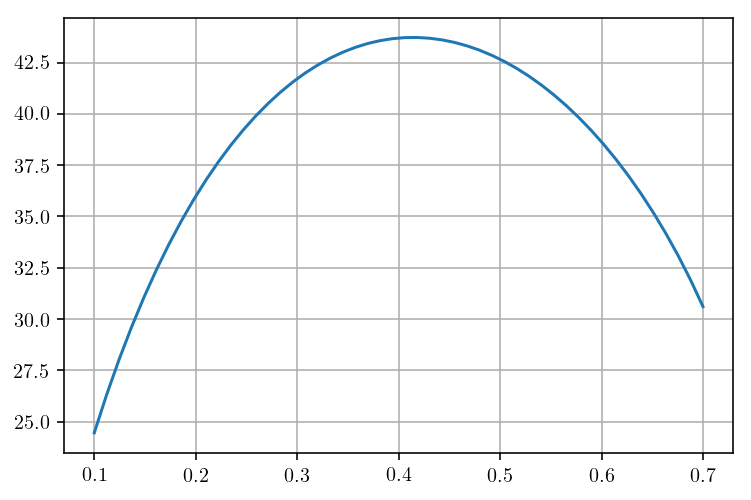

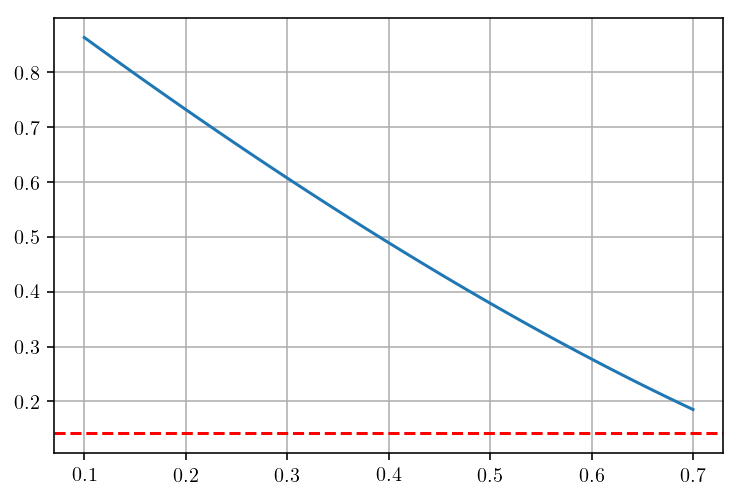

In [4]:
def integrate_trap(f, a, b, args=None, N=100):
    '''
    Uses trapezoidol rule to approximate
    integrate of f(x) from a to b
    '''
    delta_x = (b-a) / float(N)
    xk = np.linspace(a + delta_x, b - delta_x, N-1)
    return delta_x / 2. * (f(a, *args) + 2 * np.sum(f(xk, *args)) + f(b, *args))

def d_Ur_dmu(mu, rho_w, p0, pa, Vt, ms, alpha, n):
    return (Vt * np.sqrt(2. * rho_w * ((1. - alpha)**n * p0 * mu**(-n) - pa)) / 
            (rho_w * Vt * (1. - mu) + mf))

mf = ms + ml + mf
alphav = np.linspace(0.1, 0.7)
Delta_U_r = np.zeros_like(alphav)

pfv = (1. - alphav)**n * p0
pf = (1. - alpha)**n * p0

Uef = np.sqrt(2 * (pf - pa) / rho_w)
mdotf = Ae * Uef * rho_w
Tf = mdotf * Uef
amax = Tf / mf

print "Maximum acceleration: %.1f G" % (amax/g0)

for i, a in enumerate(alphav):
    Delta_U_r[i] = integrate_trap(d_Ur_dmu, 1. - a, 1, args=(rho_w, p0, pa, Vt, mf, a, n))

plt.figure()
plt.plot(alphav, Delta_U_r)

plt.figure()
plt.plot(alphav, pfv / p0)
plt.axhline(pa / p0, c='r', ls='--')

## Full Simulation

For this case, we will numerically integrate the trajectory of the rocket.  We will build a state-space model of the vehicle trajectory dynamics and the expulsion of mass from the rocket.  To start, with we will utilize

$$U_e = \sqrt{\frac{2 \left[p(t) - p_a\right]}{\rho_{w}}} = \sqrt{\frac{2 \left[p_0 (1-\alpha)^n \mu^{-n} - p_a\right]}{\rho_{w}}}$$

Now the governing state space equations are

$$\ddot{y} = \frac{\rho_w A_e U_e^2(\mu) - \frac{1}{2}C_dA_f\rho_a \dot{y}^2}{\rho_w V_t (1- \mu) + m_s} - g_0$$

$$\dot{\mu} = \frac{U_e(\mu) A_e}{V_t}$$

or in state-space representation:

$$d\begin{bmatrix}
        \dot{y}\\
        y\\
        \mu
    \end{bmatrix} =  
    \begin{bmatrix}
        \frac{\rho_w A_e U_e^2(\mu) - \frac{1}{2}C_dA_f\rho_a \dot{y}^2}{\rho_w V_t (1- \mu) + m_s} - g_0\\
        \dot{y}\\
        \frac{U_e A_e}{V_t}
    \end{bmatrix}$$

Assume $C_d = 0.4$ or [estimate using this](https://iopscience.iop.org/article/10.1088/0143-0807/30/5/012/pdf).

### Euler integration

For this analysis, we'll look at two different integration methods - Euler and midpoint.  They are both first-order, single-step explicit methods and are really the simplest of the numerical integration methods.

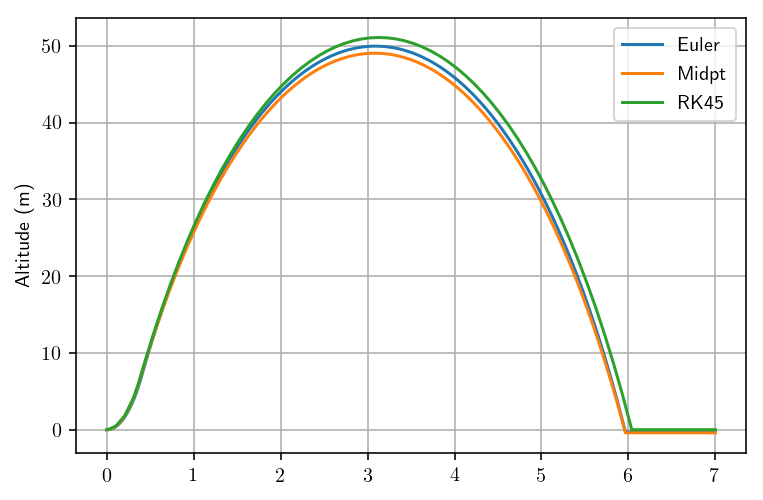

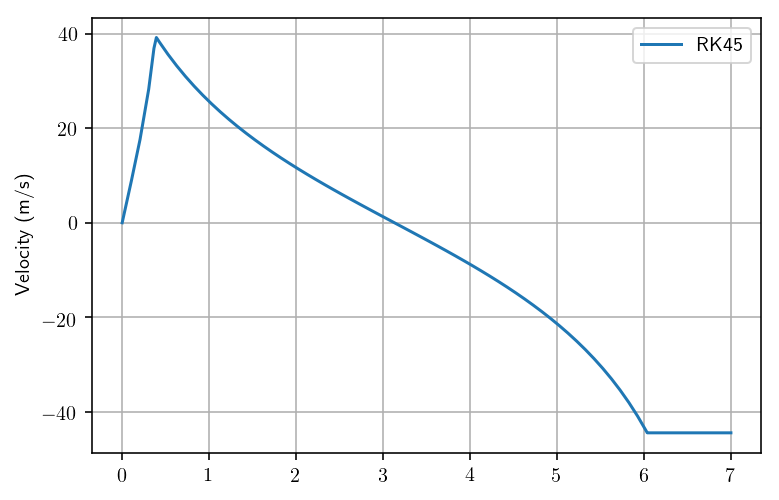

In [5]:
def euler_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i], x[i-1, :])
    
    return t, x

def midpt_integrate(df, t0, tf, x0, N=100):
    '''
    Given an ODE dx = f(t, x) 
    integrates the ODE from t0 to tf
    over N steps and returns the result.
    '''
    x = np.zeros([N, len(x0)])
    t = np.linspace(t0, tf, N)
    dt = (tf - t0) / float(N)
    x[0, :] = x0
    df0 = df(t0, x0)
    df_last = df0
    for i in range(1,N):
        x[i, :] = x[i-1, :] + dt * df(t[i] + dt / 2., x[i-1, :] + dt / 2. * df_last)
    
    return t, x

def df(t, x):
    yd = x[0]
    y = x[1]
    mu = x[2]
    dx = np.zeros([3])
    
    Ue = np.sqrt(2. * (p0 * (1 - alpha)**n * mu**(-n) - pa) / rho_w)
    
    # Check if we're out of water
    
    if y < 0.:
        dx[0] = 0.
        dx[1] = 0.
    elif mu >= 1.:
        dx[0] = ((- 0.5 * Cd * Af * rho_a * yd**2) /
             (rho_w * Vt * (1-mu) + mf) - g0)
        dx[1] = yd
        dx[2] = 0.
    else:
        dx[0] = ((rho_w * Ae * Ue**2 - 0.5 * Cd * Af * rho_a * yd**2) /
             (rho_w * Vt * (1-mu) + mf) - g0)
        dx[1] = yd
        dx[2] = Ue * Ae / Vt
        
    return dx

t, x = euler_integrate(df, 0, 7, [0, 0, 1. - alpha], N=400)
t1, x1 = midpt_integrate(df, 0, 7, [0, 0, 1. - alpha], N=400)
s_rk45 = solve_ivp(df, [0, 7], [0, 0, 1. - alpha], method='RK45', 
                   max_step=0.1, vectorized=True)

plt.figure()
plt.plot(t, x[:,1], label='Euler')
plt.plot(t1, x1[:,1], label='Midpt')
plt.plot(s_rk45.t, s_rk45.y[1, :], label='RK45')
plt.ylabel('Altitude (m)')
plt.legend()

plt.figure()
plt.plot(s_rk45.t, s_rk45.y[0, :], label='RK45')
plt.ylabel('Velocity (m/s)')
plt.legend()

Text(0,0.5,'$d_t (cm)$')

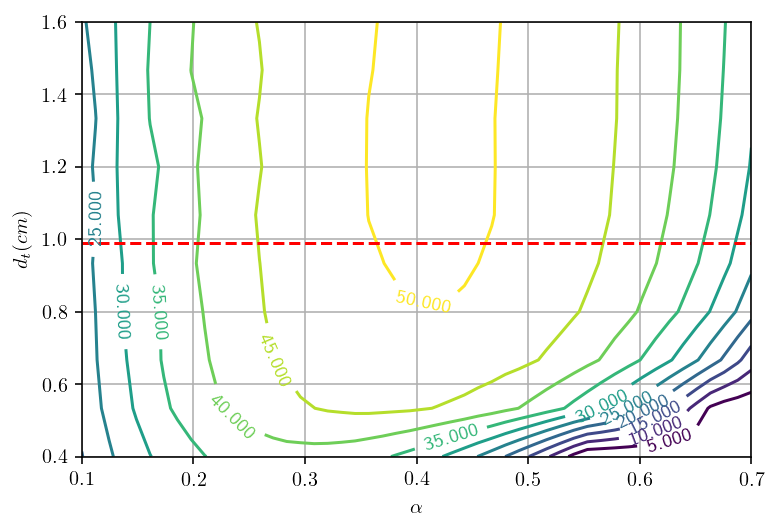

In [6]:
dt_v = np.linspace(0.4e-2, 1.6e-2, 10)

altv = np.zeros([len(dt_v), len(alphav)])

for i, d in enumerate(dt_v):
    for j, a in enumerate(alphav):
        alpha = a
        Ae = pi*d**2 / 4.
        t1, x1 = midpt_integrate(df, 0, 5, [0, 0, 1. - alpha], N=2000)
        altv[i, j] = np.max(x1[:, 1])
        
fig, ax = plt.subplots()
CS = ax.contour(alphav, dt_v*1e2, altv, 10)
ax.clabel(CS, inline=1, fontsize=10)
plt.axhline(0.39 * 2.54, c='r', ls='--')
plt.xlabel(r'$\alpha$')
plt.ylabel(r'$d_t (cm)$')

## Center of Mass

We care about the axial location of the center of mass of a body.  The general form for center of mass coordinate is:

$$\mathbf R = \frac 1M \iiint\limits_{Q}\rho(\mathbf{r}) \mathbf{r} dV$$

Given that we only care about the axial CG location, the simplest way to compute this is to assume a cross sectional linear density for the rocket and integrate its product with the axial location to compute the center of mass:

$$y_{cg} = \frac{1}{M}\int \limits_{0}^{l}\rho_L(y) y dy$$

where $\rho_L = dm/dy$ is the linear density of the rocket in kg/m for a cross section.

We compute this assuming a uniform linear density for the bottle below.

The mass is simply the bottle mass plus fin mass plus payload mass plus the volume of the water occupying the rocket.  If $y_s < r$ where $r$ is radius of the bottle, then this comes out to:

$$M = m_b + m_l + m_f + \rho_w \pi \left[y_s^2r - \frac{y_s^3}{3}\right]$$

If $y_s >=r$ this comes out to:

$$M = m_b + m_l + m_f + \rho_w \pi \left[ y_s r^2 - \frac{1}{3} r^3\right]$$

Similarily if we work out the integral above (without the $\frac{1}{M}$) and assuming the center of mass of the fins is at $y=0$, in the case of $y_s < r$ we get:

$$\int \limits_{0}^{l}\rho_L(y) y dy = \pi \rho_w\left[\frac{2r y_s^3}{3} - \frac{y_s^4}{4}\right] + \frac{\rho_{L_{bottle}} l^2}{2} + m_l l$$

And for the case where $y_s > r$ we get:

$$\int \limits_{0}^{l}\rho_L(y) y dy = \pi \rho_w\left[\frac{r^2y_s^2}{2} - \frac{r^4}{12}\right] + \frac{\rho_{L_{bottle}} l^2}{2} + m_l l$$

/Users/jonny/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


Text(0,0.5,'Mass (g)')

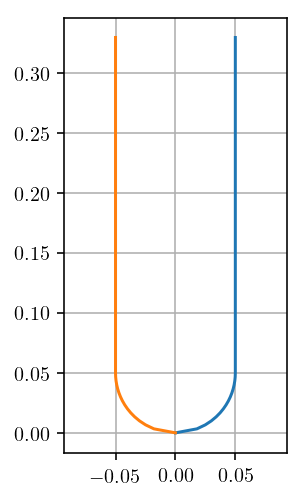

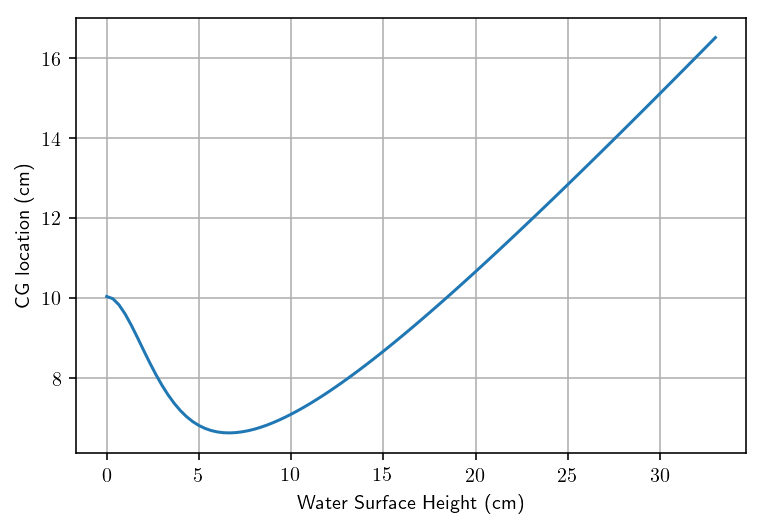

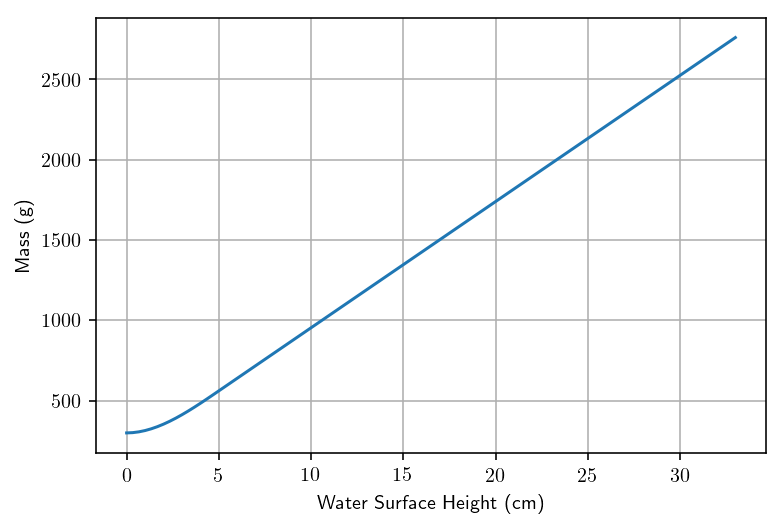

In [7]:
def cs_r(y, d):
    '''
    Function for the cross section radius
    of the bottom as a function of axial
    distance from bottom.  Assumes perfect
    hemisphere connected to cylinder.  d
    is the bottle diameter
    '''
    r = d / 2.
    return np.where(y < r, np.sqrt(r**2 - (r-y)**2), r)

def cg_ys(ys, l, d, rho_L_bottle, m_fins=0.03, m_l=0.015, rhow=1000., N=100.):
    y_cg = np.zeros_like(ys)
    yv = np.linspace(0, l, N)
    dy = yv[1] - yv[0]
    for i, ysi in enumerate(ys):
        y_cg[i] = 0.
        m = 0.
        r = cs_r(yv, d)
        for j, y in enumerate(yv):
            if y < ysi:
                rho_L = rho_L_bottle + rhow * pi * r[j]**2
            else:
                rho_L = rho_L_bottle
            y_cg[i] += y * rho_L * dy
            m += rho_L * dy
        y_cg[i] += l * m_l
        y_cg[i] /= (m + m_fins + m_l)
    return y_cg

def cg_ys_ana(ys, l, d, rho_L_bottle, m_fins=0.03, m_l=0.015, rhow=1000.):
    r = d/2.
    m = np.where(ys < r,
                 rho_L_bottle * l + m_l + m_fins + rhow * pi * (ys**2 * r - ys**3/3.), 
                 rho_L_bottle * l + m_l + m_fins + rhow * pi * (ys * r**2 - 1./3 * r**3)
                )
    ycg = np.where(ys < r,
                   pi * rhow *(2. * r * ys**3 / 3. - ys**4/4.) + 
                   rho_L_bottle * l**2 / 2 + m_l * l,
                   pi * rhow *(r**2 * ys**2/2. - r**4/12.) + 
                   rho_L_bottle * l**2 / 2 + m_l * l
            )
    ycg /= m
    return ycg, m

yv = np.linspace(0,  l, 100)
r = cs_r(yv, d_bottle)

#y_cgv = cg_ys(yv, l, d_bottle, ms / l, m_fins=mf, m_l=ml)
y_cgv1, m = cg_ys_ana(yv, l, d_bottle, ms / l, m_fins=mf, m_l=ml)

plt.figure(figsize=(2,4))
plt.plot(r, yv)
plt.plot(-r, yv)
plt.axis('equal')

plt.figure()
#plt.plot(yv*1e2, y_cgv*1e2)
plt.plot(yv*1e2, y_cgv1*1e2)
plt.xlabel('Water Surface Height (cm)')
plt.ylabel('CG location (cm)')

plt.figure()
plt.plot(yv*1e2, m*1e3)
plt.xlabel('Water Surface Height (cm)')
plt.ylabel('Mass (g)')

/Users/jonny/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt


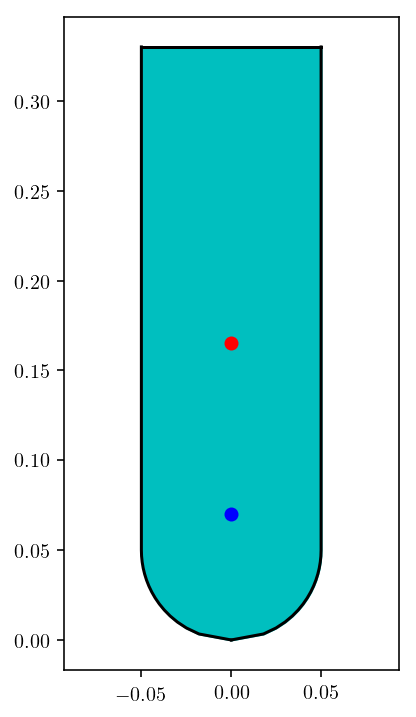

In [8]:
Cp = 7e-2
ys = 10e-2

ysv = np.linspace(0,  ys, 100)
rs = cs_r(ysv, d_bottle)

import matplotlib.animation

fig, ax = plt.subplots(figsize=(3,6))
y_cgv1, m = cg_ys_ana(ys, l, d_bottle, ms / l, m_fins=mf, m_l=ml)

ax.plot(r, yv, 'k')
ax.plot(-r, yv, 'k')
ax.plot([-r, r], [l, l], 'k')
l1, = ax.plot(0, y_cgv1, 'ro')
ax.plot(0, Cp, 'bo')
ax.fill_betweenx(ysv, -rs, rs, color='c')
ax.grid(False)
ax.axis('equal')
print(ax.collections)

ysi = np.linspace(l, 0, 100)

def animate(i):
    ysv = np.linspace(0,  ysi[i], 100)
    rs = cs_r(ysv, d_bottle)
    y_cgv1, m = cg_ys_ana(ysi[i], l, d_bottle, ms / l, m_fins=mf, m_l=ml)
    ax.collections *= 0
    l4 = ax.fill_betweenx(ysv, -rs, rs, color='c')
    l1.set_data(0, y_cgv1)

ani = matplotlib.animation.FuncAnimation(fig, animate, frames=len(ysi), interval=100)

from IPython.display import HTML
# HTML(ani.to_jshtml())

In [9]:
HTML(ani.to_html5_video())

/Users/jonny/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:10: RuntimeWarning: invalid value encountered in sqrt
